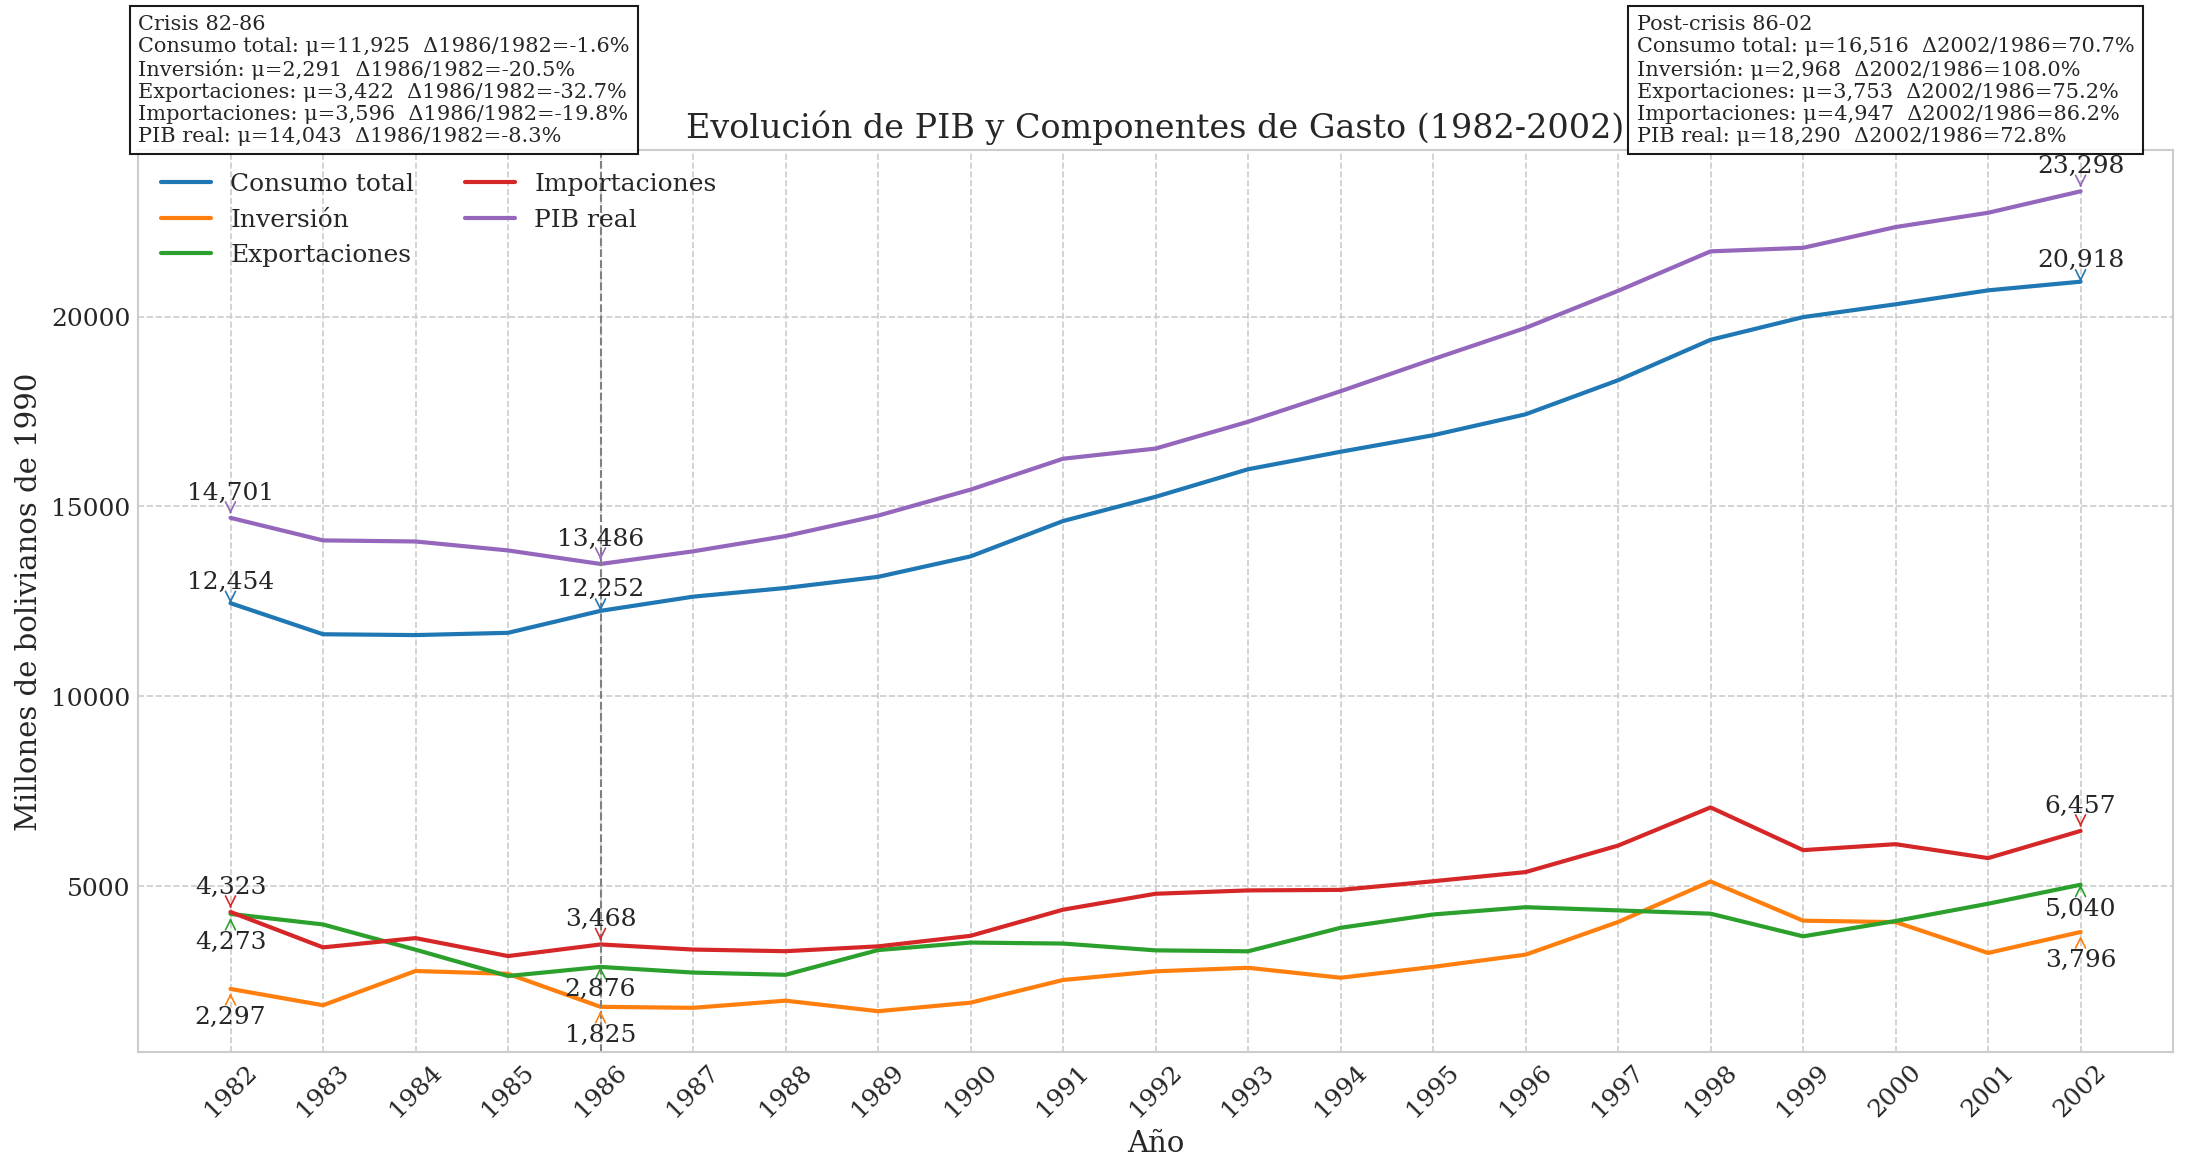

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3, os

# ---------------------------------------------------------------
# 1.  Configuración general y salida
# ---------------------------------------------------------------
output_dir = "../../../assets/tesis/neoliberalismo/serie_completa"
os.makedirs(output_dir, exist_ok=True)

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'font.family'    : 'serif',
    'font.size'      : 12,
    'axes.titlesize' : 16,
    'axes.labelsize' : 14,
    'grid.linestyle' : '--',
    'lines.linewidth': 2,
    'figure.dpi'     : 150,
    'savefig.bbox'   : 'tight'
})

# ---------------------------------------------------------------
# 2.  Carga de datos
# ---------------------------------------------------------------
conn = sqlite3.connect('../../../db/proyectomacro.db')
df = pd.read_sql("SELECT * FROM pib_real_gasto", conn)
conn.close()

df.set_index('año', inplace=True)
df = df.loc[1982:2002]          # recorte periodo
df /= 1000                      # convertir a millones

# ---------------------------------------------------------------
# 3.  Sub-periodos y componentes
# ---------------------------------------------------------------
crisis = df.loc[1982:1986]
post   = df.loc[1986:2002]

componentes = [
    ("gastos_consumo",               "Consumo total"),
    ("formacion_capital",            "Inversión"),
    ("exportacion_bienes_servicios", "Exportaciones"),
    ("importacion_bienes",           "Importaciones"),
    ("pib_real_base_1990",           "PIB real")
]

# ---------------------------------------------------------------
# 4.  Funciones de estadísticas para cuadros
# ---------------------------------------------------------------
def cuadro_stats(df_sub, year_ini, year_end):
    lineas = []
    for col, etiqueta in componentes:
        media = df_sub[col].mean()
        delta = (df.loc[year_end, col] - df.loc[year_ini, col]) / df.loc[year_ini, col] * 100
        lineas.append(f"{etiqueta}: μ={media:,.0f}  Δ{year_end}/{year_ini}={delta:.1f}%")
    return "\n".join(lineas)

texto_crisis = "Crisis 82-86\n" + cuadro_stats(crisis, 1982, 1986)
texto_post   = "Post-crisis 86-02\n" + cuadro_stats(post, 1986, 2002)
# ---------------------------------------------------------------
# 5.  Definir offsets para anotaciones
# ---------------------------------------------------------------
annotation_offsets = {
    'gastos_consumo': {
        1982: (0, 400),
        1986: (0, 400),
        2002: (0, 400),
    },
    'formacion_capital': {
        1982: (0, -900),
        1986: (0, -900),
        2002: (0, -900),
    },
    'exportacion_bienes_servicios': {
        1982: (0, -900),
        1986: (0, -760),
        2002: (0, -800),
    },
    'importacion_bienes': {
        1982: (0, 500),
        1986: (0, 500),
        2002: (0, 500),
    },
    'pib_real_base_1990': {
        1982: (0, 500),
        1986: (0, 500),
        2002: (0, 500),
    }
}
# ---------------------------------------------------------------
# 6.  Gráfico
# ---------------------------------------------------------------
fig, ax = plt.subplots(figsize=(15, 8))
cmap = plt.get_cmap('tab10')

for i, (col, etiqueta) in enumerate(componentes):
    ax.plot(df.index, df[col],
            label=etiqueta,
            color=cmap(i))

# Línea divisoria 1986
ax.axvline(1986, color='gray', linestyle='--', linewidth=1)

# Anotaciones 82-86-02
for col, _ in componentes:
    if col in ['consumo_privado', 'consumo_publico']:
        continue
    for year in (1982, 1986, 2002):
        if year in df.index:
            y = df.loc[year, col]
            dx, dy = annotation_offsets[col].get(year, (0, y*0.05))
            ax.annotate(f"{y:,.0f}",
                        xy=(year, y),
                        xytext=(year + dx, y + dy),
                        textcoords='data',
                        ha='center',
                        fontsize=12,
                        arrowprops=dict(arrowstyle='->', color=cmap(componentes.index((col, _))), linewidth=0.8))

# Cuadros de texto
ybox = df.max().max() * 1.20
ax.text(1981, ybox, texto_crisis,
        fontsize=10, va='top',
        bbox=dict(facecolor='white', edgecolor='black', alpha=0.9))

ax.text(1997.2, ybox, texto_post,
        fontsize=10, va='top',
        bbox=dict(facecolor='white', edgecolor='black', alpha=0.9))

# Etiquetas y formato
ax.set_title("Evolución de PIB y Componentes de Gasto (1982-2002)")
ax.set_xlabel("Año")
ax.set_ylabel("Millones de bolivianos de 1990")
ax.set_xticks(range(1982, 2003))
ax.tick_params(axis='x', rotation=45)
ax.legend(loc='upper left', ncol=2)
plt.tight_layout()

plt.savefig(os.path.join(output_dir, "pib_componentes_82_02.png"))
plt.show()